In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from src import oom
from src.oom.DiscreteValuedOOM import DiscreteValuedOOM, get_matrices
from src.oom.ContinuousValuedOOM import ContinuousValuedOOM
from src.oom.observable import *
from src.main import experiment_dimension

sys.modules['oom'] = oom

import itertools
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt

import scipy as sp

from IPython import display
# hdisplay = display.display("", display_id=True)

In [43]:
membership_fns = []

n_obs = 8
arg_sum = 64

for idx in range(1, n_obs + 1):
    offset = arg_sum / 2 * (n_obs + 1 - 2*idx) / (n_obs + 1)
    athis = arg_sum / 2 - offset
    bthis = arg_sum / 2 + offset
    
    pdf = sp.stats.beta(a = athis, b = bthis, loc = 0, scale = 1)
    membership_fns.append(pdf)

In [44]:
alphabet_size = 8
dimension = 10
sparsity = 0.9

oom_disc = DiscreteValuedOOM.from_sparse(
    alphabet_size = alphabet_size,
    dimension = dimension,
    density = 1 - sparsity,
    deterministic_functional = False,
    stationary_state = False,
    seed = None
)
oom_cont = ContinuousValuedOOM(
    dim = oom_disc.dim,
    linear_functional = oom_disc.lin_func,
    operators = oom_disc.operators,
    start_state = oom_disc.start_state,
    membership_functions = membership_fns,
)

In [45]:
generation_cont = oom_cont.generate(10000)

In [46]:
generation_disc = oom_disc.generate(10000)

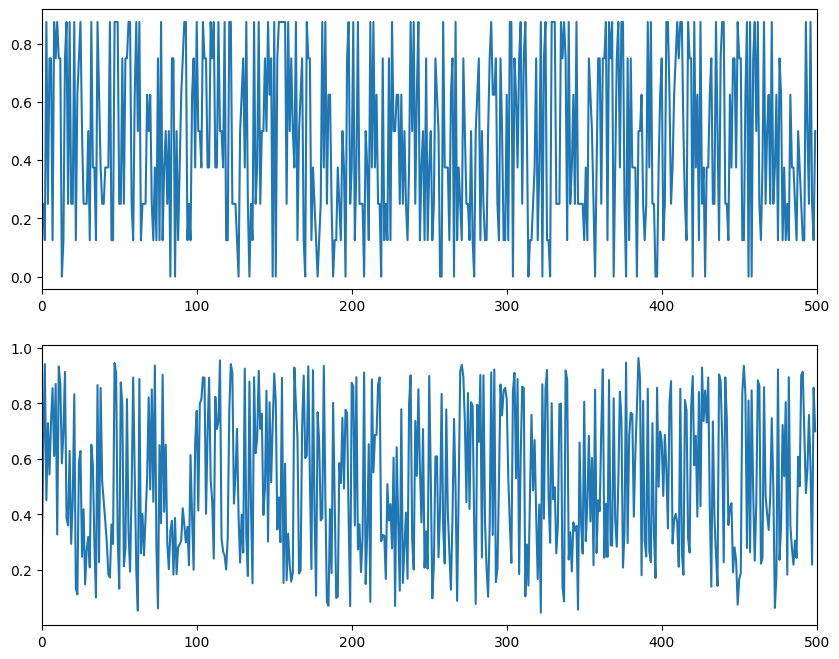

In [47]:
fig, axs = plt.subplots(2, 1, figsize = (10, 8))
axs = axs.flatten()

xmax = 500

axs[0].plot([oom_disc.observables.index(i) / len(oom_disc.observables) for i in generation_disc.sequence[:xmax]])
axs[1].plot(generation_cont.sequence[:xmax])

for ax in axs:
    ax.set_xlim([0, xmax])

plt.show()

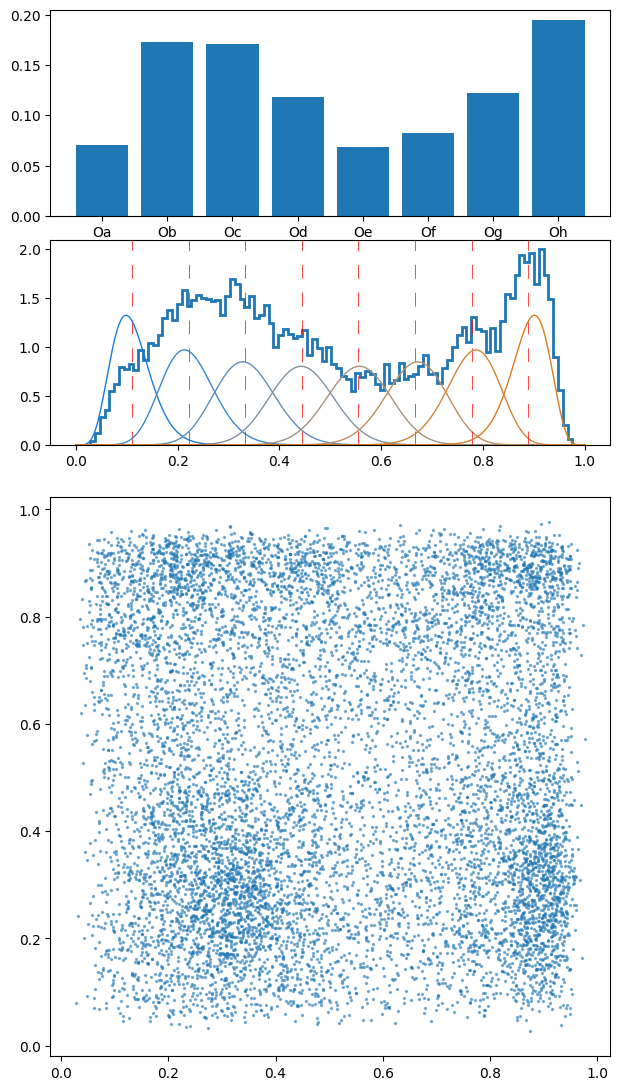

In [61]:
fig, axs = plt.subplots(3, 1, figsize = (6, 11), sharex = 'row', height_ratios = [1, 1, 3])
axs = axs.flatten()

ser = pd.Series([obs.uid for obs in generation_disc.sequence])
ser = ser.value_counts(normalize = True)
ser = ser.sort_index(key = lambda x: x.str.ljust(5, 'z'))

axs[0].bar(
    x = range(1, len(ser.index) + 1),
    height = ser
)
axs[0].set_xticks(
    ticks = range(1, len(ser.index) + 1),
    labels = list(ser.index)
)


axs[1].hist(
    generation_cont.sequence,
    bins = 100,
    density = True,
    histtype = 'step',
    linewidth = 2,
    zorder = -5,
)

support = np.linspace(0, 1, 1000)
x_vlines = np.linspace(0, 1, (n_obs + 1) + 1, endpoint = True)[1 : -1]

n_obs = len(oom_cont.observables)
arg_sum = 64

for idx, xv in zip(range(1, n_obs + 1), x_vlines):
    axs[1].axvline(xv, color = 'r', linewidth = 0.5, linestyle = (0, (20, 20)))
    
    offset = arg_sum / 2 * (n_obs + 1 - 2*idx) / (n_obs + 1)
    athis = arg_sum / 2 - offset
    bthis = arg_sum / 2 + offset
    color = np.array([athis, arg_sum / 2, bthis])
    color = color / np.linalg.norm(color)
    
    pdf = oom_cont.membership_fns[idx - 1].pdf(support) / n_obs
    axs[1].plot(support, pdf, linewidth = 1, color = color)

axs[2].scatter(
    x = generation_cont.sequence[:-1],
    y = generation_cont.sequence[1:],
    s = 2,
    alpha = 0.5
)
axs[2].set_box_aspect(1)

fig.set_layout_engine('tight', pad = 0)

plt.show()

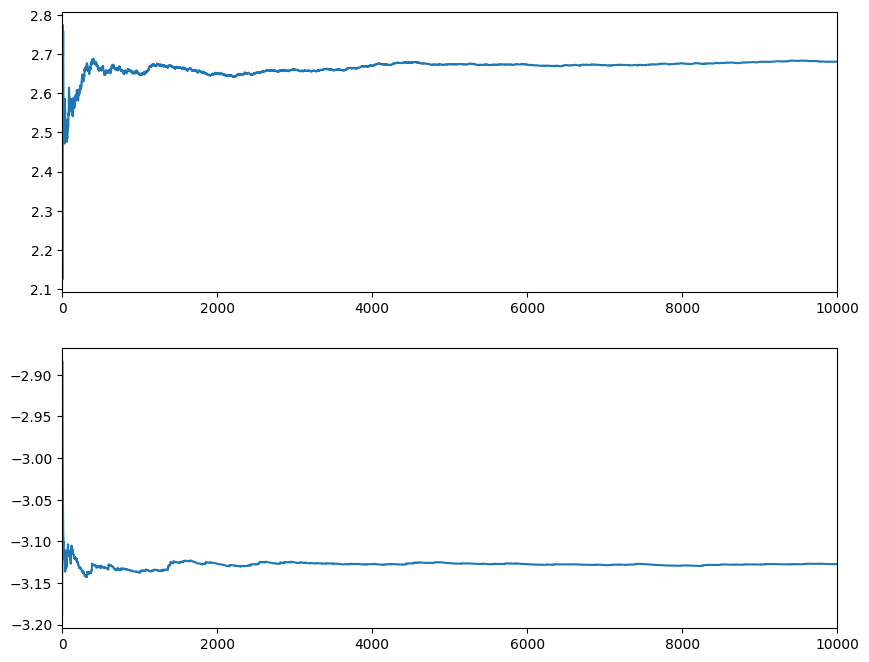

In [49]:
fig, axs = plt.subplots(2, 1, figsize = (10, 8))
axs = axs.flatten()

axs[0].plot(generation_disc.nll_list)
axs[1].plot(generation_cont.nll_list)

for ax in axs:
    ax.set_xlim([0, len(generation_disc.sequence)])

plt.show()